In [1]:
pip install transformers torch datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import os

In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [5]:
def create_text_file(df, output_file):
    with open(output_file, "w", encoding="utf-8") as f:
        for index, row in df.iterrows():
            f.write(f"Input: {row['Input Text']}\nTarget: {row['Target Text']}\n\n")

In [6]:
def load_dataset(file_path, tokenizer, block_size=128):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )
    return dataset

In [8]:
def main():
    csv_file_path = "Movies.csv"

    try:
        df = pd.read_csv(csv_file_path)
        df = df.dropna()
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

        train_file_path = "train_movies.txt"
        create_text_file(train_df, train_file_path)

        train_dataset = load_dataset(train_file_path, tokenizer)

        data_collator = DataCollatorForLanguageModeling(
            tokenizer=tokenizer, mlm=False
        )

        training_args = TrainingArguments(
            output_dir="./gpt2-finetuned",
            overwrite_output_dir=True,
            num_train_epochs=3,
            per_device_train_batch_size=2,
            save_steps=10_000,
            save_total_limit=2,
            logging_dir="./logs",
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=train_dataset,
        )

        trainer.train()

        trainer.save_model("./gpt2-finetuned")
        tokenizer.save_pretrained("./gpt2-finetuned")

        os.remove(train_file_path)

        print("Fine-tuning completed successfully!")

    except FileNotFoundError:
        print(f"Error: File not found at {csv_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Fine-tuning completed successfully!


In [10]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

model_path = "./gpt2-finetuned"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)


prompts = [
    "Input: The Godfather is considered one of the greatest  Target:"
]


for prompt in prompts:
    generated_text = generator(prompt, max_length=100, num_return_sequences=1)[0]['generated_text']
    print("Prompt:", prompt)
    print("Generated Text:", generated_text)
    print("-" * 50)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Input: The Godfather is considered one of the greatest  Target:
Generated Text: Input: The Godfather is considered one of the greatest  Target: Star Trek  - was originally conceived as a Star Trek film and featured a Klingon named Kirk in his twenties.  When the film was released in 1966, the franchise had already won many awards, including the Academy's Best Picture (for which the Academy has nominated three other such films), and won The Best Picture (for which the Academy had nominated three other such films) among its top ten nominees.  With two
--------------------------------------------------


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import pandas as pd
from sklearn.model_selection import train_test_split
import os

os.environ["WANDB_DISABLED"] = "true"

# Load the tokenizer and model
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

# Prepare the dataset
def create_text_file(df, output_file):
    with open(output_file, "w", encoding="utf-8") as f:
        for index, row in df.iterrows():
            f.write(f"Input: {row['Input Text']}\nTarget: {row['Target Text']}\n\n")

def load_dataset(file_path, tokenizer, block_size=128):
    dataset = TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )
    return dataset

def main():
    # Path to your movies.csv dataset
    csv_file_path = "Movies.csv"  # Replace with your actual CSV path

    try:
        # Load the CSV file
        df = pd.read_csv(csv_file_path)

        # Handle missing values if any
        df = df.dropna()

        # Split the dataset into training and testing sets
        train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

        # Create text files for training
        train_file_path = "train_movies.txt"
        create_text_file(train_df, train_file_path)

        # Load the dataset
        train_dataset = load_dataset(train_file_path, tokenizer)

        # Data collator
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=tokenizer, mlm=False
        )

        # Training arguments
        training_args = TrainingArguments(
            output_dir="./gpt2-finetuned",
            overwrite_output_dir=True,
            num_train_epochs=3,
            per_device_train_batch_size=2,
            save_steps=10_000,
            save_total_limit=2,
            logging_dir="./logs",
        )

        # Trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            data_collator=data_collator,
            train_dataset=train_dataset,
        )

        # Fine-tune the model
        trainer.train()

        # Save the model
        trainer.save_model("./gpt2-finetuned")
        tokenizer.save_pretrained("./gpt2-finetuned")

        # Clean up the text file.
        os.remove(train_file_path)

        print("Fine-tuning completed successfully!")

    except FileNotFoundError:
        print(f"Error: File not found at {csv_file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

/usr/local/lib/python3.11/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss


Fine-tuning completed successfully!


In [9]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

model_path = "./gpt2-finetuned"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

prompts = [
    "Input: The Godfather is considered one of the greatest  Target:"
]

for prompt in prompts:
    generated_text = generator(prompt, max_length=100, num_return_sequences=1)[0]['generated_text']
    print("Prompt:", prompt)
    print("Generated Text:", generated_text)
    print("-" * 50)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Input: The Godfather is considered one of the greatest  Target:
Generated Text: Input: The Godfather is considered one of the greatest  Target: AMC Original Movie of all time

In the series, a man finds himself in possession of an old copy of the Bible written in the year 1000 and asks a Godfather who is still alive for information. The Godfather decides that this is as important as any book about God: all are to be made of God.

It will not do.

The movie is set in a world ruled by supernatural forces.
--------------------------------------------------


In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, pipeline

# 1. Load the Fine-Tuned Model and Tokenizer
model_path = "./gpt2-finetuned"
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model = GPT2LMHeadModel.from_pretrained(model_path)

# 2. Generate Text (using pipeline for simplicity)
generator = pipeline('text-generation', model=model, tokenizer=tokenizer)

# Example Prompts
prompts = [
    "Input: The Godfather is considered one of the greatest  Target:"
]

# Generate Text for Each Prompt
for prompt in prompts:
    generated_text = generator(prompt, max_length=100, num_return_sequences=1)[0]['generated_text']
    print("Prompt:", prompt)
    print("Generated Text:", generated_text)
    print("-" * 50)

# 3. Evaluate the Output (Manual Inspection)
# Manually read the generated text and see if it makes sense and matches your expected output.
# If you have a test dataset, you can use automated metrics.

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Prompt: Input: The Godfather is considered one of the greatest  Target:
Generated Text: Input: The Godfather is considered one of the greatest  Target: The Fault In Our Stars The title of the film is based on the novel by Oscar winning poet Alfred Hitchcock and features a dark hero of the early 20th Century with a murderous, murderous, and powerful wife who is obsessed with vengeance. In this film, she is the daughter of a crime lord, an assassin, and a vampire whose master desires more than anything to be the ultimate hero of his class. Her father was a powerful
--------------------------------------------------


In [ ]:
pip install transformers diffusers torch flax jax jaxlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


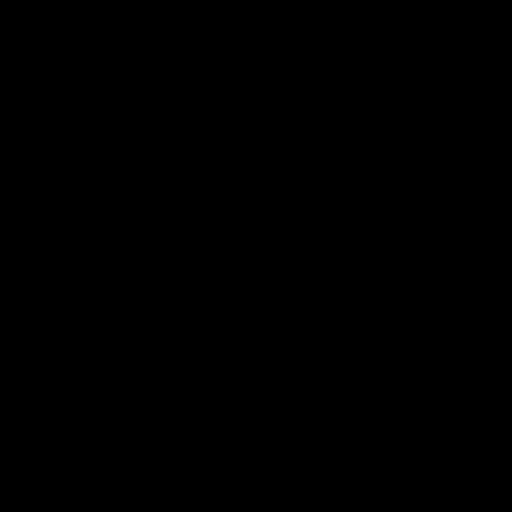

In [ ]:
                                                                                                                                                                   from diffusers import StableDiffusionPipeline
#!pip install transformers diffusers torch accelerate

import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from IPython.display import display

# Check if GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the Stable Diffusion model and tokenizer
model_id = "CompVis/stable-diffusion-v1-4"

# Load the pipeline
pipe = StableDiffusionPipeline.from_pretrained(model_id)
pipe = pipe.to(device)

# Text prompt for image generation
prompt = "Cat eating a pizza"

# Generate the image
image = pipe(prompt).images[0]

# Display the image in Colab
display(image)

# Save the image (optional)
image.save("generated_image.png")